In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import json
from PIL import Image, ImageDraw
from image_gen_aux import DepthPreprocessor
from controlnet_aux import CannyDetector
from diffusers import FluxControlPipeline, FluxPriorReduxPipeline, FluxFillPipeline
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from utils import down_size

/amax/hchuz/miniconda3/envs/py310/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
pipe_prior_redux = FluxPriorReduxPipeline.from_pretrained("black-forest-labs/FLUX.1-Redux-dev", torch_dtype=torch.bfloat16).to('cuda')

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# control
model_id = "black-forest-labs/FLUX.1-dev"
pipe = FluxControlPipeline.from_pretrained(model_id, 
                                            text_encoder=None,
                                            text_encoder_2=None,
                                            torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload()
pipe.load_lora_weights("/amax/hchuz/hfd_models/FLUX.1-Canny-dev-lora", adapter_name="canny")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [5]:
# paras
pipe.set_adapters("canny", 0.85)
if 'dev' in model_id:
    kwargs = {
            'guidance_scale':2.5,
            'num_inference_steps':20,
        }
else:
    kwargs={
        'guidance_scale':0,
        'num_inference_steps':4
    }

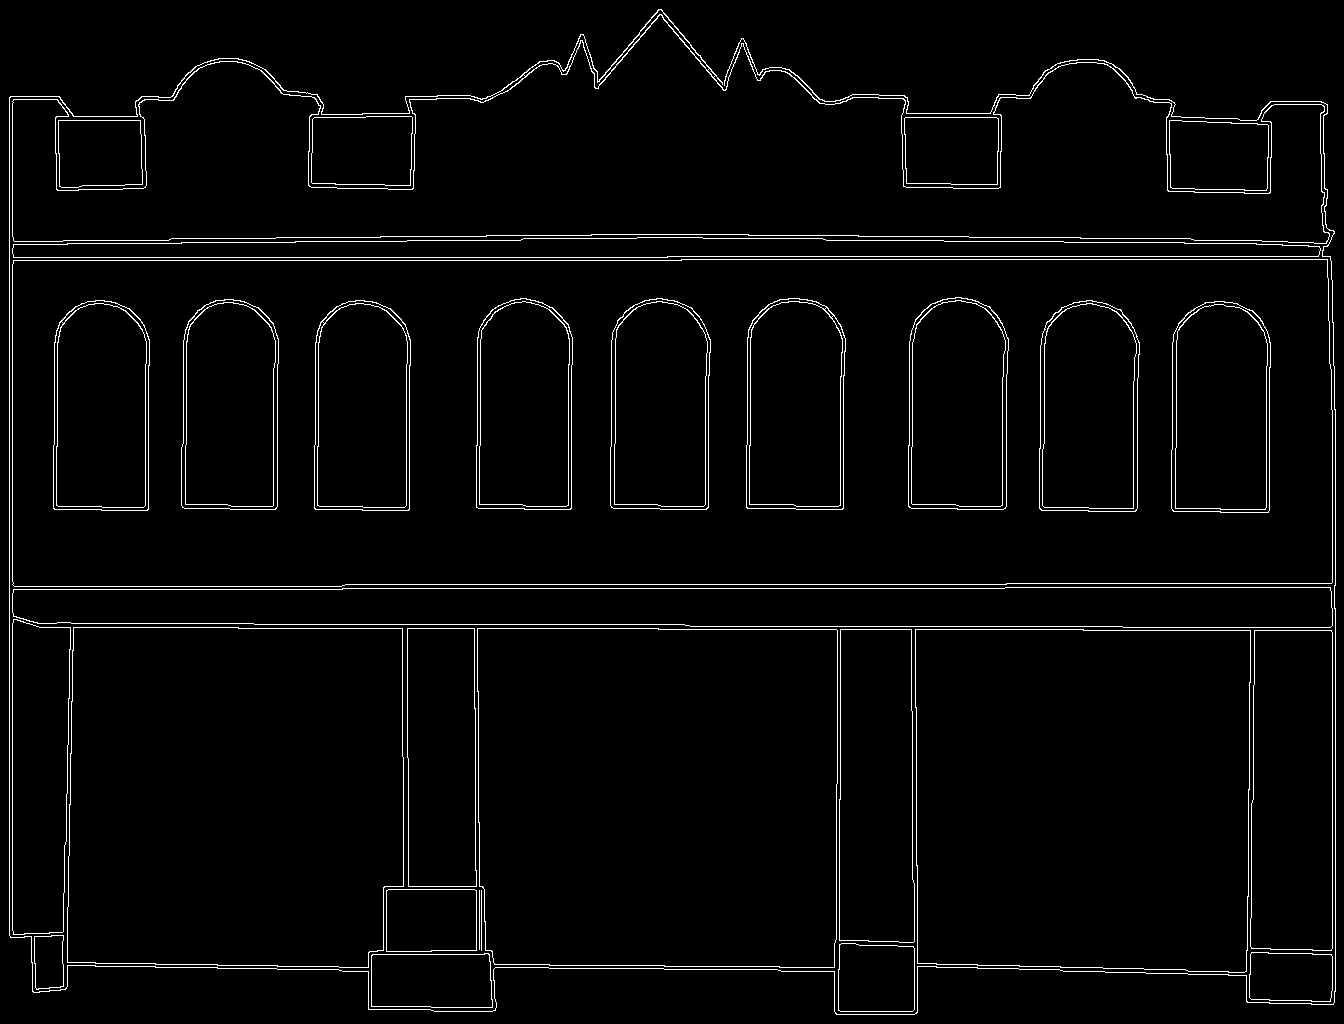

In [6]:
control_image = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-06_canny.png')
control_image

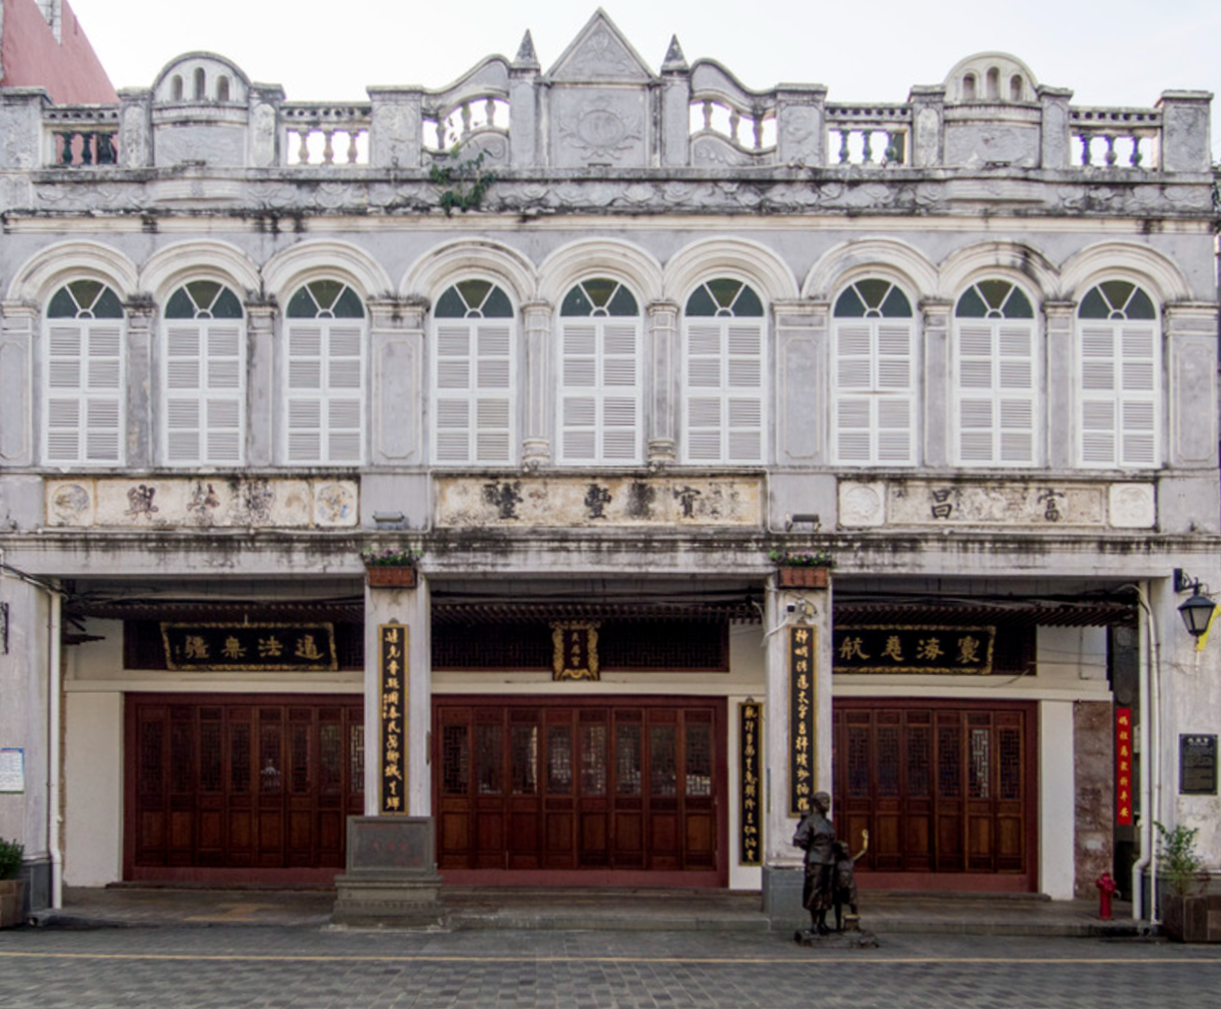

In [9]:
global_style_image = Image.open(os.path.join('temp', 'Snipaste_2023-02-21_13-33-06.png')).convert('RGB')
global_style_image

In [7]:
control_image_ = control_image

  0%|          | 0/20 [00:00<?, ?it/s]

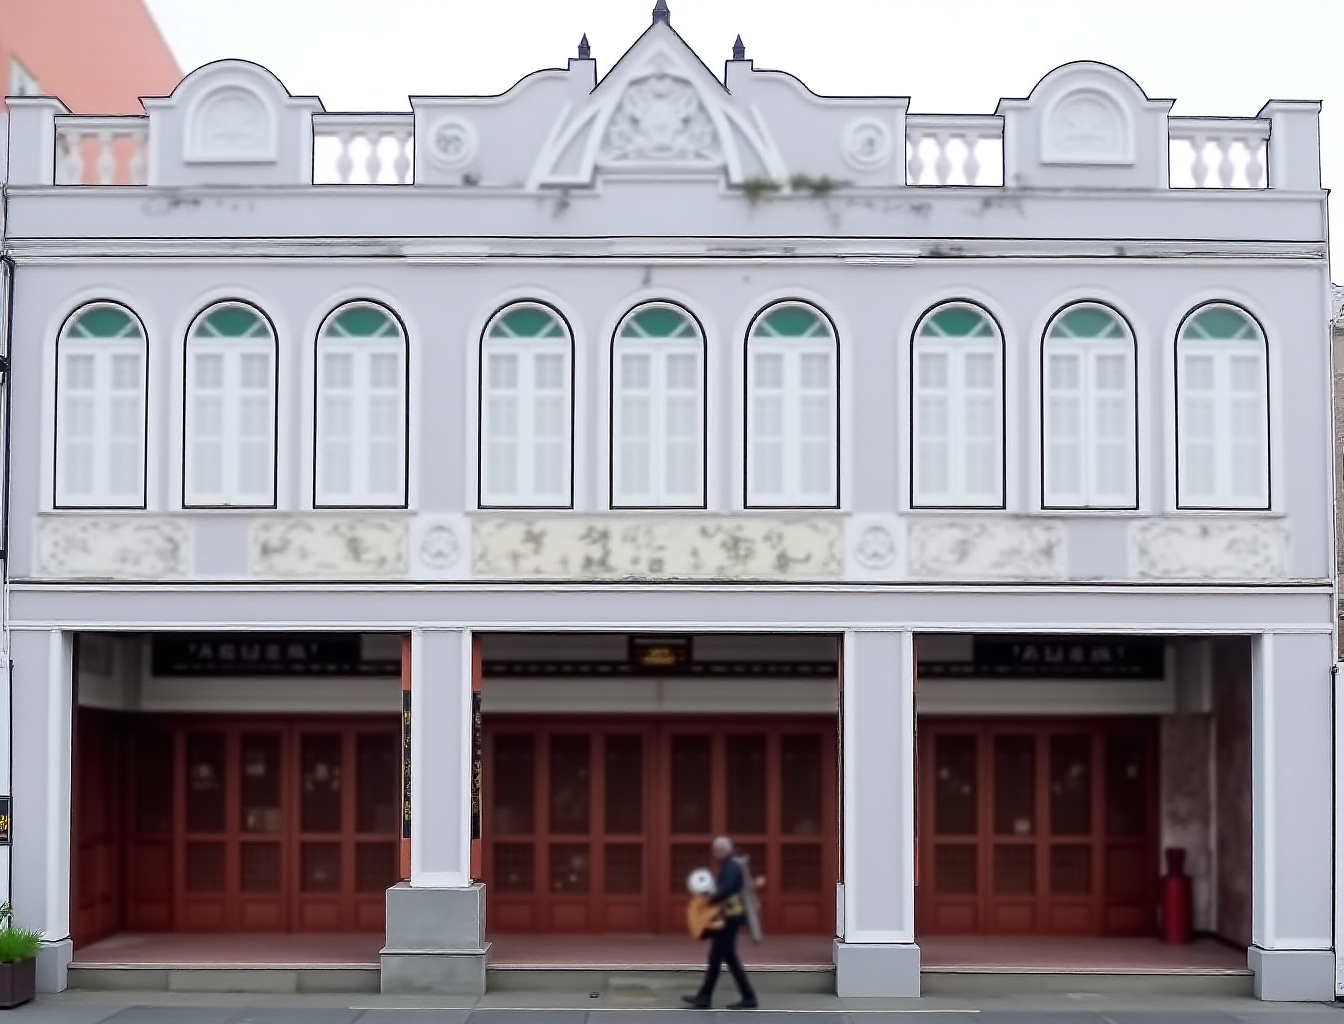

In [10]:
#seed = random.randint(0,10000)
seed = 4803
pipe_prior_output = pipe_prior_redux(global_style_image)
image = pipe(
    **kwargs,
    control_image=control_image,
    height = control_image.height,
    width = control_image.width,
    generator=torch.Generator("cpu").manual_seed(seed),
    **pipe_prior_output,
).images[0]
image

In [ ]:
#image.save('temp/Snipaste_2023-02-21_13-33-51_gen.png')

In [12]:
image = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-51_gen.png')

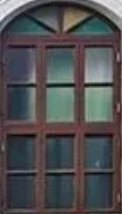

In [14]:
style_image = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-51_window.png')
style_image

In [1]:
mask_image = Image.open('/amax/hchuz/architectural_heritage/temp/mask_all.png')
mask_image

NameError: name 'Image' is not defined

In [16]:
pipe2 = FluxFillPipeline.from_pretrained("/amax/hchuz/hfd_models/FLUX.1-Fill-dev", 
                                            text_encoder=None,
                                            text_encoder_2=None,
                                            torch_dtype=torch.bfloat16)
pipe2.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

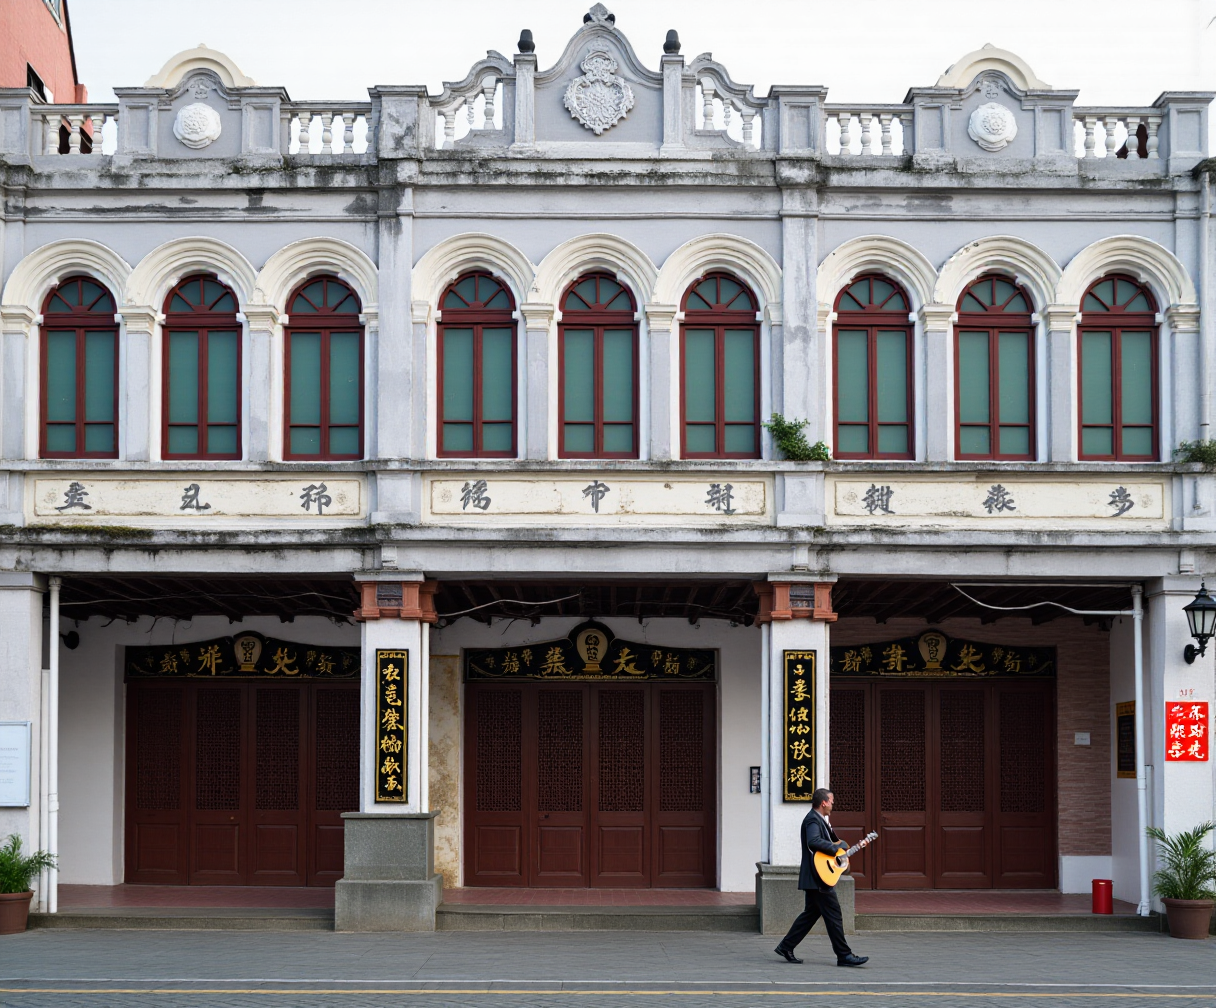

In [17]:
pipe_prior_output = pipe_prior_redux(style_image)
image2 = pipe2(
    image=image,
    mask_image=mask_image,
    height=image.height,
    width=image.width,
    guidance_scale=30,
    num_inference_steps=20,
    generator=torch.Generator("cpu").manual_seed(seed),
    **pipe_prior_output
).images[0]
image2